# Automated Insurance Claim Fraud Detection System

## Feature Overview
- **age**: Age of the policyholder.
- **policy_number**: Unique identifier for the insurance policy.
- **claim_amount**: Amount claimed in the insurance.
- **fraud_reported**: Whether the claim was fraudulent (Y/N).
...

## Import Libraries

In [262]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score

## Overview of the data

In [263]:
df = pd.read_csv("vendor_data.xls", encoding='utf-8', engine='python')
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   VENDOR_ID      600 non-null    object
 1   VENDOR_NAME    600 non-null    object
 2   ADDRESS_LINE1  600 non-null    object
 3   ADDRESS_LINE2  97 non-null     object
 4   CITY           594 non-null    object
 5   STATE          600 non-null    object
 6   POSTAL_CODE    600 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 32.9+ KB


In [264]:
df = pd.read_csv("employee_data.xls", encoding='utf-8', engine='python')
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AGENT_ID            1200 non-null   object
 1   AGENT_NAME          1200 non-null   object
 2   DATE_OF_JOINING     1200 non-null   object
 3   ADDRESS_LINE1       1200 non-null   object
 4   ADDRESS_LINE2       179 non-null    object
 5   CITY                1193 non-null   object
 6   STATE               1200 non-null   object
 7   POSTAL_CODE         1200 non-null   int64 
 8   EMP_ROUTING_NUMBER  1200 non-null   int64 
 9   EMP_ACCT_NUMBER     1200 non-null   object
dtypes: int64(2), object(8)
memory usage: 93.9+ KB


## Load the Datasets

In [265]:
insurance_df = pd.read_csv("insurance_data.csv")
vendor_df = pd.read_csv("vendor_data.xls", encoding='utf-8', engine='python')
employee_df = pd.read_csv("employee_data.xls", encoding='utf-8', engine='python')

## Columns in each dataset

In [266]:
print("insurance_data.csv columns:", insurance_df.columns.tolist())
print("vendor_data.xls columns:", vendor_df.columns.tolist())
print("employee_data.xls columns:", employee_df.columns.tolist())

insurance_data.csv columns: ['TXN_DATE_TIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER', 'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'INSURANCE_TYPE', 'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CUSTOMER_NAME', 'ADDRESS_LINE1', 'ADDRESS_LINE2', 'CITY', 'STATE', 'POSTAL_CODE', 'SSN', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'ROUTING_NUMBER', 'ACCT_NUMBER', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_CITY', 'INCIDENT_HOUR_OF_THE_DAY', 'AGENT_ID', 'VENDOR_ID']
vendor_data.xls columns: ['VENDOR_ID', 'VENDOR_NAME', 'ADDRESS_LINE1', 'ADDRESS_LINE2', 'CITY', 'STATE', 'POSTAL_CODE']
employee_data.xls columns: ['AGENT_ID', 'AGENT_NAME', 'DATE_OF_JOINING', 'ADDRESS_LINE1', 'ADDRESS_LINE2', 'CITY', 'STATE', 'POSTAL_CODE', 'EMP_ROUTING_NUMBER', 'EMP_ACCT_NUMBER']


##  Clean Column Names

In [267]:
insurance_df.columns = insurance_df.columns.str.strip().str.lower()
vendor_df.columns = vendor_df.columns.str.strip().str.lower()
employee_df.columns = employee_df.columns.str.strip().str.lower()

##  Merge on vendor_id and agent_id

In [268]:
vendor_df.rename(columns={'acct_number': 'vendor_acct_number'}, inplace=True)
df = insurance_df.merge(vendor_df, on="vendor_id", how="left")
df = df.merge(employee_df, on="agent_id", how="left")

## Drop unwanted columns


In [269]:
drop_cols = [
    'txn_date_time', 'customer_name', 'address_line1', 'address_line2',
    'routing_number', 'emp_routing_number', 'emp_acct_number',
    'ssn', 'agent_name', 'vendor_name', 'city', 'state', 'postal_code',
    'policy_eff_dt', 'loss_dt', 'report_dt', 'date_of_joining'
    
]

df.drop(columns=drop_cols, inplace=True, errors='ignore')

## Drop rows with missing claim_status


In [270]:
df = df[df['claim_status'].notnull()]

##  Fill missing values

In [271]:
df.fillna(0, inplace=True)

## Drop columns with personal or redundant info


In [272]:
cols_to_drop = [
    'txn_date_time', 'customer_name', 'address_line1', 'address_line2',
    'routing_number', 'acct_number', 'emp_routing_number', 'emp_acct_number',
    'ssn', 'agent_name', 'vendor_name', 'city', 'state', 'postal_code',
    'policy_eff_dt', 'loss_dt', 'report_dt', 'date_of_joining'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Drop rows with missing target
df = df[df['claim_status'].notnull()]

# Fill NA
df.fillna(0, inplace=True)


##  Encode categorical variables


In [273]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col].astype(str))

##  Create New Features

In [274]:
df["claim_to_premium_ratio"] = df["claim_amount"] / (df["premium_amount"] + 1)
df["family_size"] = df["no_of_family_members"] + 1
df["claim_per_person"] = df["claim_amount"] / df["family_size"]

##  Feature Columns


In [275]:
features = [
    'premium_amount', 'claim_amount', 'age', 'tenure', 'no_of_family_members',
    'incident_hour_of_the_day', 'employment_status', 'house_type', 'social_class',
    'incident_severity', 'authority_contacted', 'any_injury',
    'police_report_available', 'insurance_type', 'customer_education_level',
    'risk_segmentation', 'claim_to_premium_ratio', 'claim_per_person'
]
X = df[features]

In [276]:
print("Unique values in 'claim_status':", df['claim_status'].unique())

Unique values in 'claim_status': [0 1]


##  Set y directly since it's already 0/1 encoded


In [277]:
y = df['claim_status']

##  Train-Test Split

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

## Handle Imbalance with SMOTE


In [279]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


##  Train XGBoost Model

In [280]:
clf = XGBClassifier(eval_metric='logloss', random_state=42)
clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

##  Train Isolation Forest for anomaly detection


In [281]:
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

## Risk Scoring


In [282]:
proba = clf.predict_proba(X_test)[:, 1]
anomalies = iso.predict(X_test)
risk_score = proba + (anomalies == -1) * 0.5

## Investigation Queue


In [283]:
results = df.iloc[X_test.index].copy()
results["predicted"] = clf.predict(X_test)
results["true_label"] = y_test.values
results["risk_score"] = risk_score
results["priority"] = pd.qcut(risk_score, 3, labels=["Low", "Medium", "High"])

## Show Top High-Risk Claims


In [284]:
print("\n Top 10 High-Risk Claims for Investigation:\n")
display(
    results[["transaction_id", "risk_score", "priority", "predicted", "true_label"]]
    .sort_values(by="risk_score", ascending=False)
    .head(10)
)


 Top 10 High-Risk Claims for Investigation:



,transaction_id,risk_score,priority,predicted,true_label
1091,1091,1.459999,High,1,0
8738,8738,1.371087,High,1,0
6181,6181,1.319621,High,1,0
1487,1487,1.277720,High,1,0
546,546,1.168991,High,1,0
2908,2908,1.097914,High,1,0
7442,7442,1.074705,High,1,1
2636,2636,1.051368,High,1,0
7848,7848,1.013731,High,1,0
7830,7830,0.995930,High,1,0


## Model Evaluation


In [285]:
print("\n Classification Report:\n")
print(classification_report(y_test, results["predicted"]))
print("ROC AUC Score:", roc_auc_score(y_test, proba))


 Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2849
           1       0.06      0.07      0.06       151

    accuracy                           0.90      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.91      0.90      0.90      3000

ROC AUC Score: 0.5285181973923696


In [286]:
print("Available columns before Network Analysis:", df.columns.tolist())

Available columns before Network Analysis: ['transaction_id', 'customer_id', 'policy_number', 'insurance_type', 'premium_amount', 'claim_amount', 'address_line1_x', 'address_line2_x', 'city_x', 'state_x', 'postal_code_x', 'marital_status', 'age', 'tenure', 'employment_status', 'no_of_family_members', 'risk_segmentation', 'house_type', 'social_class', 'customer_education_level', 'claim_status', 'incident_severity', 'authority_contacted', 'any_injury', 'police_report_available', 'incident_state', 'incident_city', 'incident_hour_of_the_day', 'agent_id', 'vendor_id', 'address_line1_y', 'address_line2_y', 'city_y', 'state_y', 'postal_code_y', 'claim_to_premium_ratio', 'family_size', 'claim_per_person']


## Network analysis for organized fraud

In [288]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph based on shared entities among transactions
G = nx.Graph()

# Link transactions sharing the same agent
if 'agent_id' in df.columns:
    agent_groups = df.groupby('agent_id')['transaction_id'].apply(list)
    for txns in agent_groups:
        if len(txns) > 1:
            for i in range(len(txns)):
                for j in range(i+1, len(txns)):
                    G.add_edge(txns[i], txns[j], relation='shared_agent')
    print(f" Added edges for shared agents: {len(agent_groups)} agent groups")

# Link transactions sharing the same account number
account_columns = [col for col in df.columns if 'acct' in col.lower() or 'account' in col.lower()]
for account_col in account_columns:
    if account_col in df.columns:
        acct_groups = df.groupby(account_col)['transaction_id'].apply(list)
        for txns in acct_groups:
            if len(txns) > 1:
                for i in range(len(txns)):
                    for j in range(i+1, len(txns)):
                        G.add_edge(txns[i], txns[j], relation=f'shared_{account_col}')
        print(f" Added edges for {account_col}: {len(acct_groups)} account groups")
        break

# Link transactions through shared vendor IDs
if 'vendor_id' in df.columns:
    vendor_groups = df.groupby('vendor_id')['transaction_id'].apply(list)
    for txns in vendor_groups:
        if len(txns) > 1:
            for i in range(len(txns)):
                for j in range(i+1, len(txns)):
                    G.add_edge(txns[i], txns[j], relation='shared_vendor')
    print(f" Added edges for shared vendors: {len(vendor_groups)} vendor groups")

# Assign fraud labels to graph nodes
for node in G.nodes:
    txn_row = df[df['transaction_id'] == node]
    if not txn_row.empty:
        G.nodes[node]['label'] = int(txn_row['claim_status'].values[0])

print(f" Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Community detection and visualization
if G.number_of_nodes() > 0:
    from networkx.algorithms.community import greedy_modularity_communities
    
    communities = list(greedy_modularity_communities(G))
    print(f" Detected {len(communities)} potential fraud rings or connected claim communities")
    
    largest = max(communities, key=len)
    if 1 < len(largest) <= 100:
        subgraph = G.subgraph(largest)
        plt.figure(figsize=(12, 8))
        node_colors = ['red' if G.nodes[n].get('label') == 1 else 'lightgreen' if G.nodes[n].get('label') == 0 else 'gray' for n in subgraph.nodes]
        pos = nx.spring_layout(subgraph, k=1, iterations=50)
        nx.draw(subgraph, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.7)
        plt.title(f"Largest Suspicious Transaction Network ({len(largest)} nodes)")
        plt.legend(['Red: Denied Claims', 'Green: Approved Claims', 'Gray: Unknown'], loc='upper right')
        plt.show()
    else:
        print(f" Largest community has {len(largest)} nodes - not visualized")

    # Identify communities with high fraud concentration
    fraud_communities = []
    for i, community in enumerate(communities):
        if len(community) > 2:
            fraud_count = sum(1 for node in community if G.nodes[node].get('label', 0) == 1)
            fraud_rate = fraud_count / len(community)
            if fraud_rate > 0.5:
                fraud_communities.append({
                    'community_id': i,
                    'size': len(community),
                    'fraud_count': fraud_count,
                    'fraud_rate': fraud_rate
                })

    if fraud_communities:
        print("\n High-risk fraud communities (>50% fraud rate):")
        for fc in sorted(fraud_communities, key=lambda x: x['fraud_rate'], reverse=True)[:5]:
            print(f"  Community {fc['community_id']}: {fc['size']} claims, "
                  f"{fc['fraud_count']} fraudulent ({fc['fraud_rate']:.1%})")
    else:
        print("\n No high-risk fraud communities detected")
else:
    print(" No network connections found - check if transaction_id and grouping columns exist")

 Added edges for shared agents: 1200 agent groups
 Added edges for shared vendors: 408 vendor groups
 Network created with 10000 nodes and 5356260 edges
 Detected 2 potential fraud rings or connected claim communities
 Largest community has 6822 nodes - not visualized

 No high-risk fraud communities detected


## Generating the plots

C:\Users\vudut\AppData\Local\Temp\ipykernel_3268\3811325539.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=insurance_df, x='claim_status_label', palette='Set2')


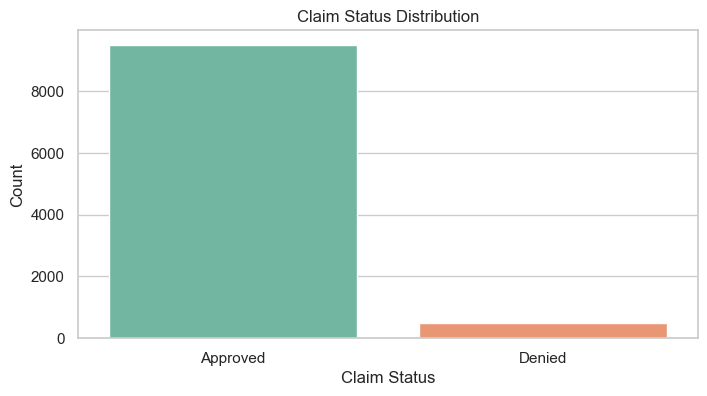

In [289]:
sns.set(style="whitegrid")

# Claim Status Distribution
status_map = {'A': 'Approved', 'D': 'Denied'}
insurance_df['claim_status_label'] = insurance_df['claim_status'].map(status_map)
plt.figure(figsize=(8,4))
sns.countplot(data=insurance_df, x='claim_status_label', palette='Set2')
plt.title('Claim Status Distribution')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.show()


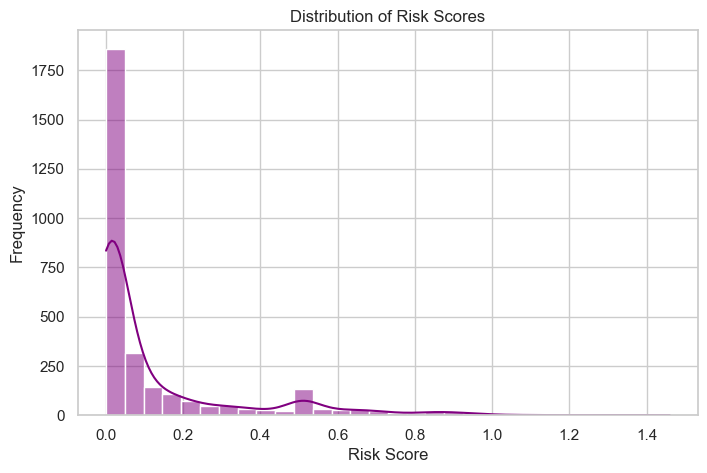

In [290]:

# Risk Score Distribution
plt.figure(figsize=(8,5))
sns.histplot(results['risk_score'], kde=True, bins=30, color='purple')
plt.title("Distribution of Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.show()


C:\Users\vudut\AppData\Local\Temp\ipykernel_3268\373900068.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='priority', data=results, palette="coolwarm")


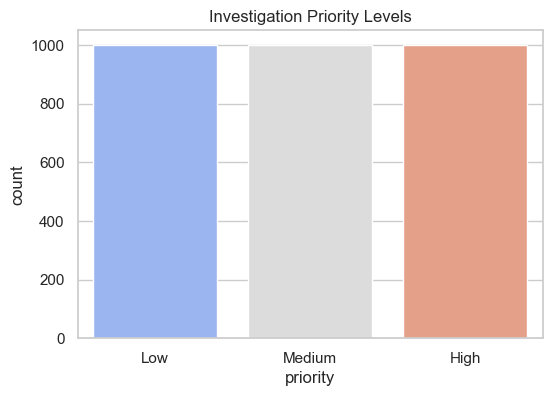

In [291]:
# Priority Breakdown
plt.figure(figsize=(6,4))
sns.countplot(x='priority', data=results, palette="coolwarm")
plt.title("Investigation Priority Levels")
plt.show()


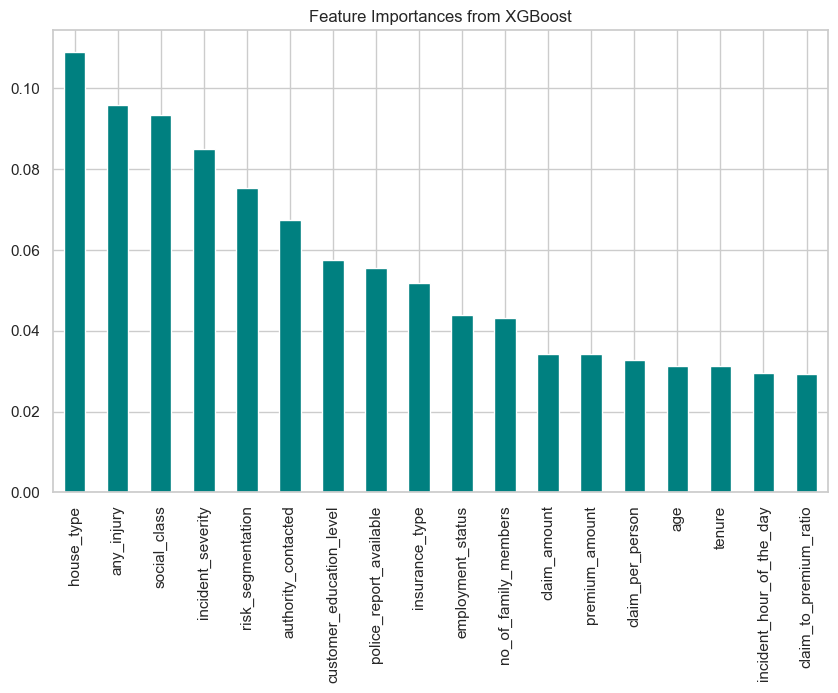

In [292]:
# Feature Importance
importances = clf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar', color='teal')
plt.title("Feature Importances from XGBoost")
plt.show()

## Saving the models

In [293]:
from joblib import dump

# Save XGBoost model
clf.save_model('xgboost_model.json')

# Save Isolation Forest model
dump(iso, 'isolation_forest.joblib')

['isolation_forest.joblib']

## Streamlit Interface

In [295]:
from streamlit_jupyter import StreamlitPopen, get_streamlit_file_content
# Load and run the Streamlit app
app_code = get_streamlit_file_content("app.py")
StreamlitPopen(app_code=app_code)

ImportError: cannot import name 'StreamlitPopen' from 'streamlit_jupyter' (c:\Users\vudut\anaconda3\envs\nlp\Lib\site-packages\streamlit_jupyter\__init__.py)